<a href="https://colab.research.google.com/drive/19HG9VTvAEf2eYCBG5ntwNkshl9KiElDU?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<i>Time Series Forecasting for Covid</i><br>
--
Coded by : Dani Johanes

In [1]:
!pip install -Uq watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.6.9
IPython 5.5.0

numpy 1.19.4
pandas 1.1.5
torch 1.7.0+cu101


In [3]:
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [10]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [12]:
# Download dataset using wget terminal command in colab!

!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2020-12-30 15:54:36--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 411850 (402K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>] 402.20K  --.-KB/s    in 0.01s   

2020-12-30 15:54:36 (33.4 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [411850/411850]



In [13]:
!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 30.5MB/s]


In [16]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91


In [17]:
# Getting rid!

df = df.iloc[:, 4:]

In [18]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990
1,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414
2,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576
3,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296
4,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91


In [19]:
df.isnull().sum().sum()

0

In [21]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)

In [24]:
print(daily_cases.head(20))

2020-01-22      555
2020-01-23      653
2020-01-24      941
2020-01-25     1434
2020-01-26     2118
2020-01-27     2927
2020-01-28     5578
2020-01-29     6166
2020-01-30     8234
2020-01-31     9927
2020-02-01    12038
2020-02-02    16787
2020-02-03    19881
2020-02-04    23892
2020-02-05    27636
2020-02-06    30818
2020-02-07    34392
2020-02-08    37121
2020-02-09    40151
2020-02-10    42763
dtype: int64


Text(0.5, 1.0, 'Daily cases (Cumulative)')

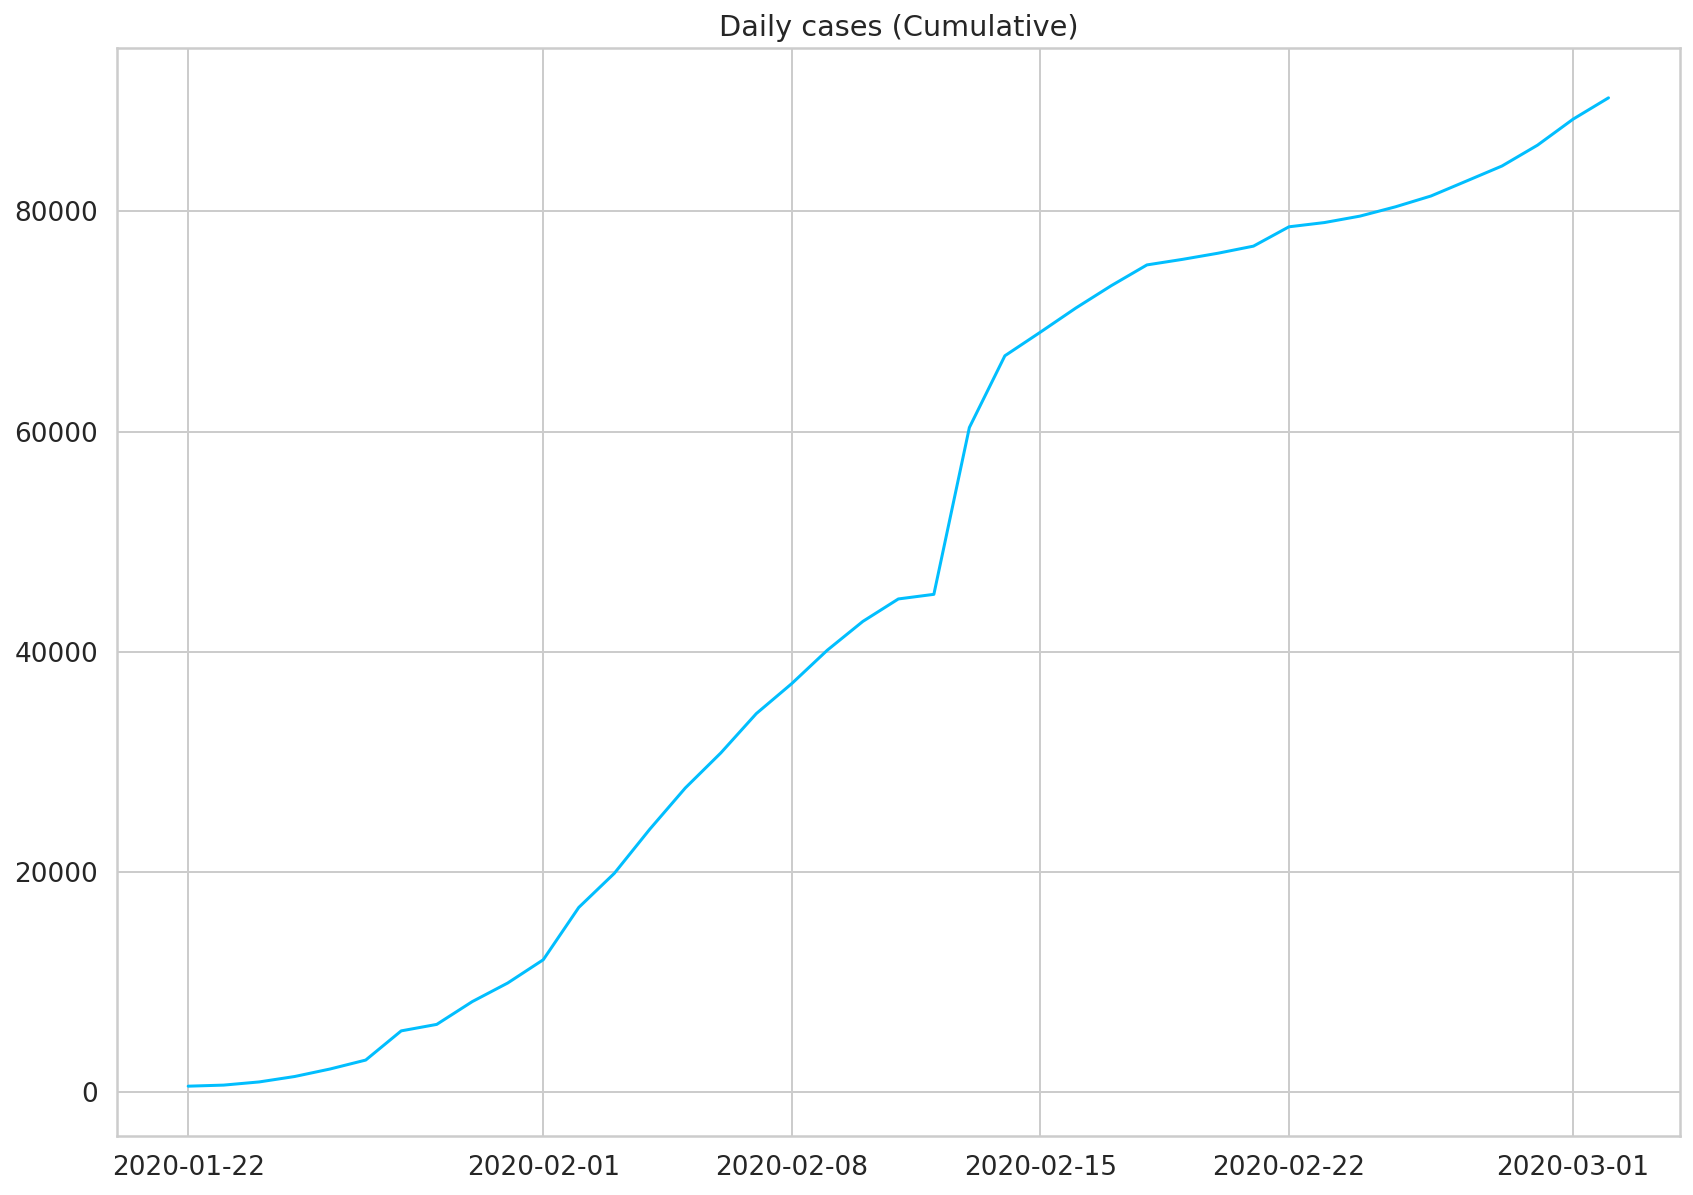

In [26]:
plt.plot(daily_cases)
plt.title("Daily cases (Cumulative)")

In [27]:
# Undo
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

Text(0.5, 1.0, 'Daily cases')

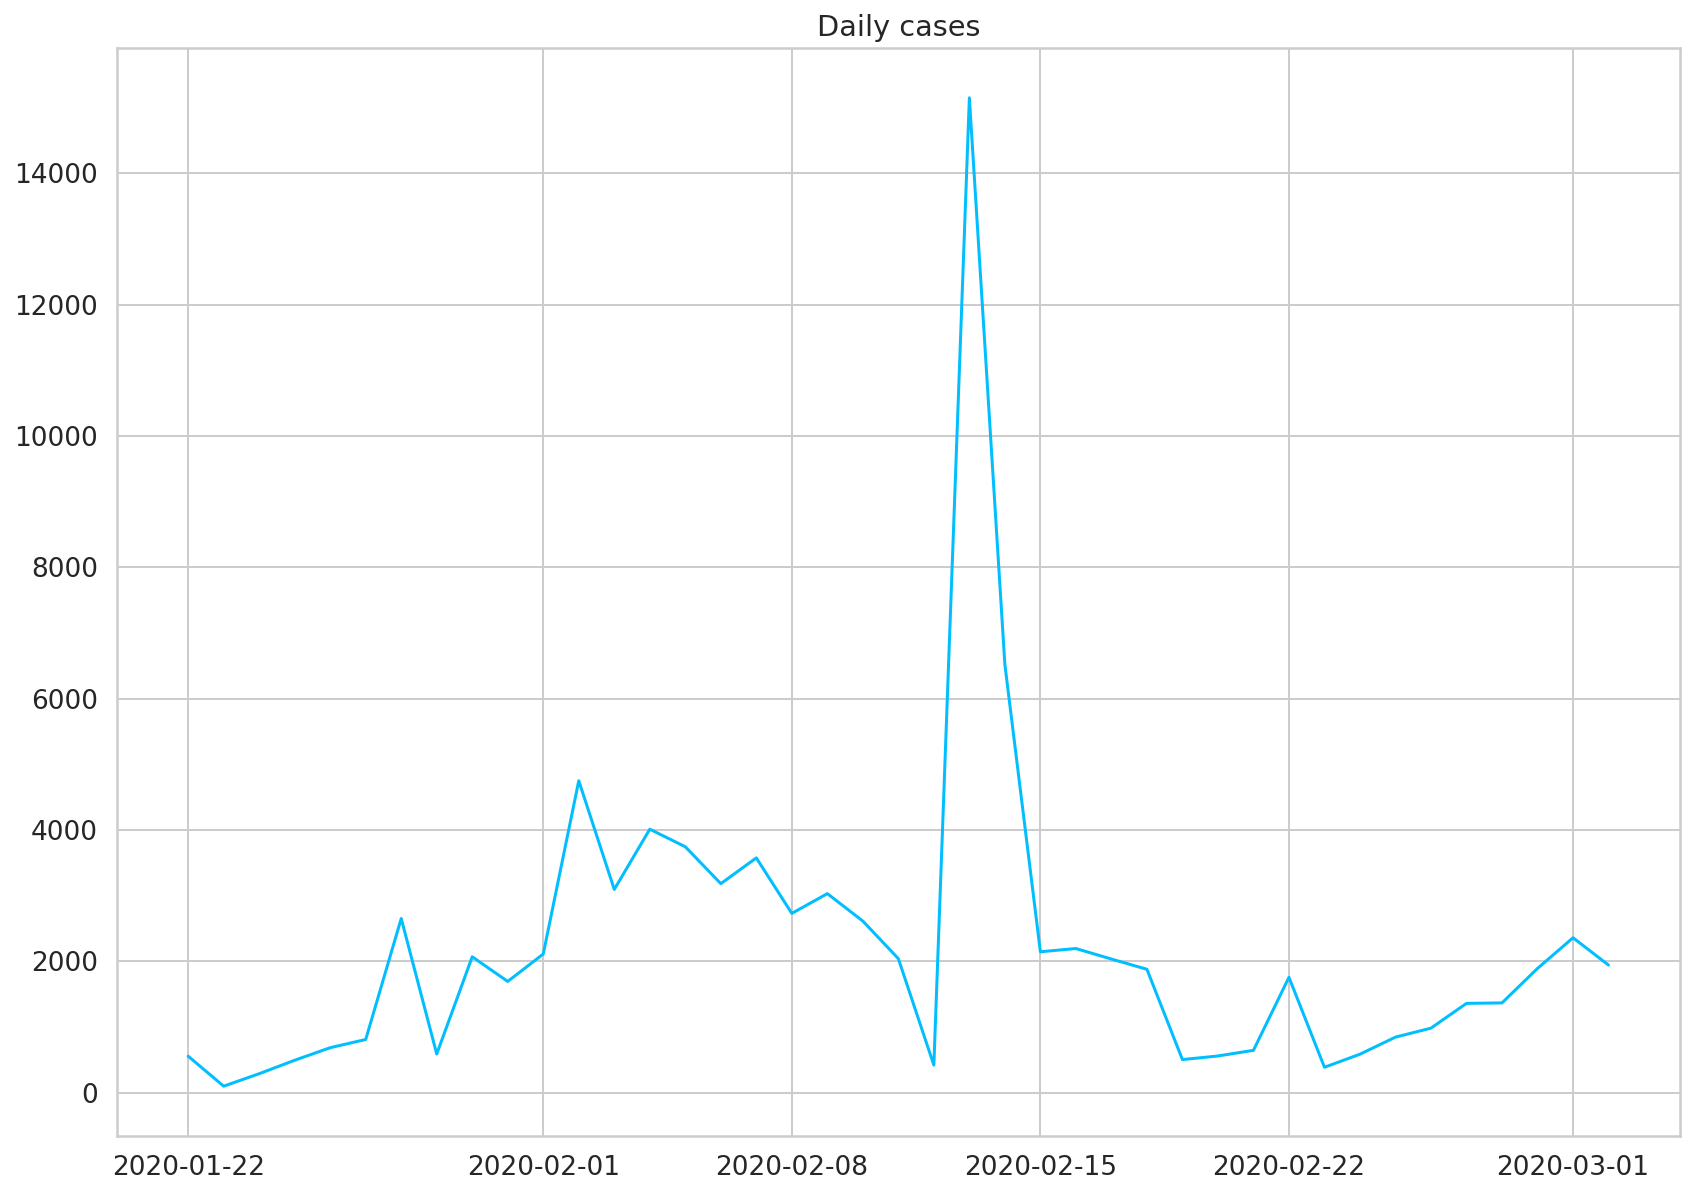

In [28]:
plt.plot(daily_cases)
plt.title("Daily cases")

In [29]:
# Check the amount of the data!
daily_cases.shape

(41,)

In [30]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(27,)

In [31]:
# Scale the data to get faster training
scaler = MinMaxScaler()

In [32]:
scaler = scaler.fit(np.expand_dims(train_data, axis=1))

In [35]:
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [36]:
train_data

array([[0.03036545],
       [0.        ],
       [0.01262458],
       [0.02624585],
       [0.03893688],
       [0.04724252],
       [0.16963455],
       [0.03255814],
       [0.13089701],
       [0.10598007],
       [0.13375415],
       [0.30903654],
       [0.19906977],
       [0.26      ],
       [0.24225914],
       [0.20491694],
       [0.23096346],
       [0.17481728],
       [0.19481728],
       [0.16704319],
       [0.12903654],
       [0.0213289 ],
       [1.        ],
       [0.42651163],
       [0.13601329],
       [0.1392691 ],
       [0.12863787]])

In [37]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [38]:
seq_length = 5

In [39]:
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [40]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

In [41]:
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [42]:
X_train

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]],

        [[0.0126],
         [0.0262],
         [0.0389],
         [0.0472],
         [0.1696]],

        [[0.0262],
         [0.0389],
         [0.0472],
         [0.1696],
         [0.0326]],

        [[0.0389],
         [0.0472],
         [0.1696],
         [0.0326],
         [0.1309]],

        [[0.0472],
         [0.1696],
         [0.0326],
         [0.1309],
         [0.1060]],

        [[0.1696],
         [0.0326],
         [0.1309],
         [0.1060],
         [0.1338]],

        [[0.0326],
         [0.1309],
         [0.1060],
         [0.1338],
         [0.3090]],

        [[0.1309],
         [0.1060],
         [0.1338],
         [0.3090],
         [0.1991]],

        [[0.1060],
         [0.1338],
         [0.3090],
         [0.1991],
         [0.2600]],

        [[0.1338],
         [0

In [43]:
X_train.shape

torch.Size([21, 5, 1])

In [44]:
print(X_train[:2])

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]]])


In [45]:
print(y_train.shape)

torch.Size([21, 1])


In [46]:
y_train[:2]

tensor([[0.0472],
        [0.1696]])

In [47]:
train_data[:10]

array([[0.03036545],
       [0.        ],
       [0.01262458],
       [0.02624585],
       [0.03893688],
       [0.04724252],
       [0.16963455],
       [0.03255814],
       [0.13089701],
       [0.10598007]])

In [48]:
# Build the network architecture!

class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [51]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    optimiser.zero_grad()

    loss.backward()
    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [52]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 1.7019871473312378 test loss: 0.05128774791955948
Epoch 10 train loss: 0.8228673338890076 test loss: 0.1246221587061882
Epoch 20 train loss: 0.8223666548728943 test loss: 0.14668694138526917
Epoch 30 train loss: 0.8023919463157654 test loss: 0.21858201920986176
Epoch 40 train loss: 0.8213724493980408 test loss: 0.1845945566892624
Epoch 50 train loss: 0.8220521211624146 test loss: 0.20839336514472961


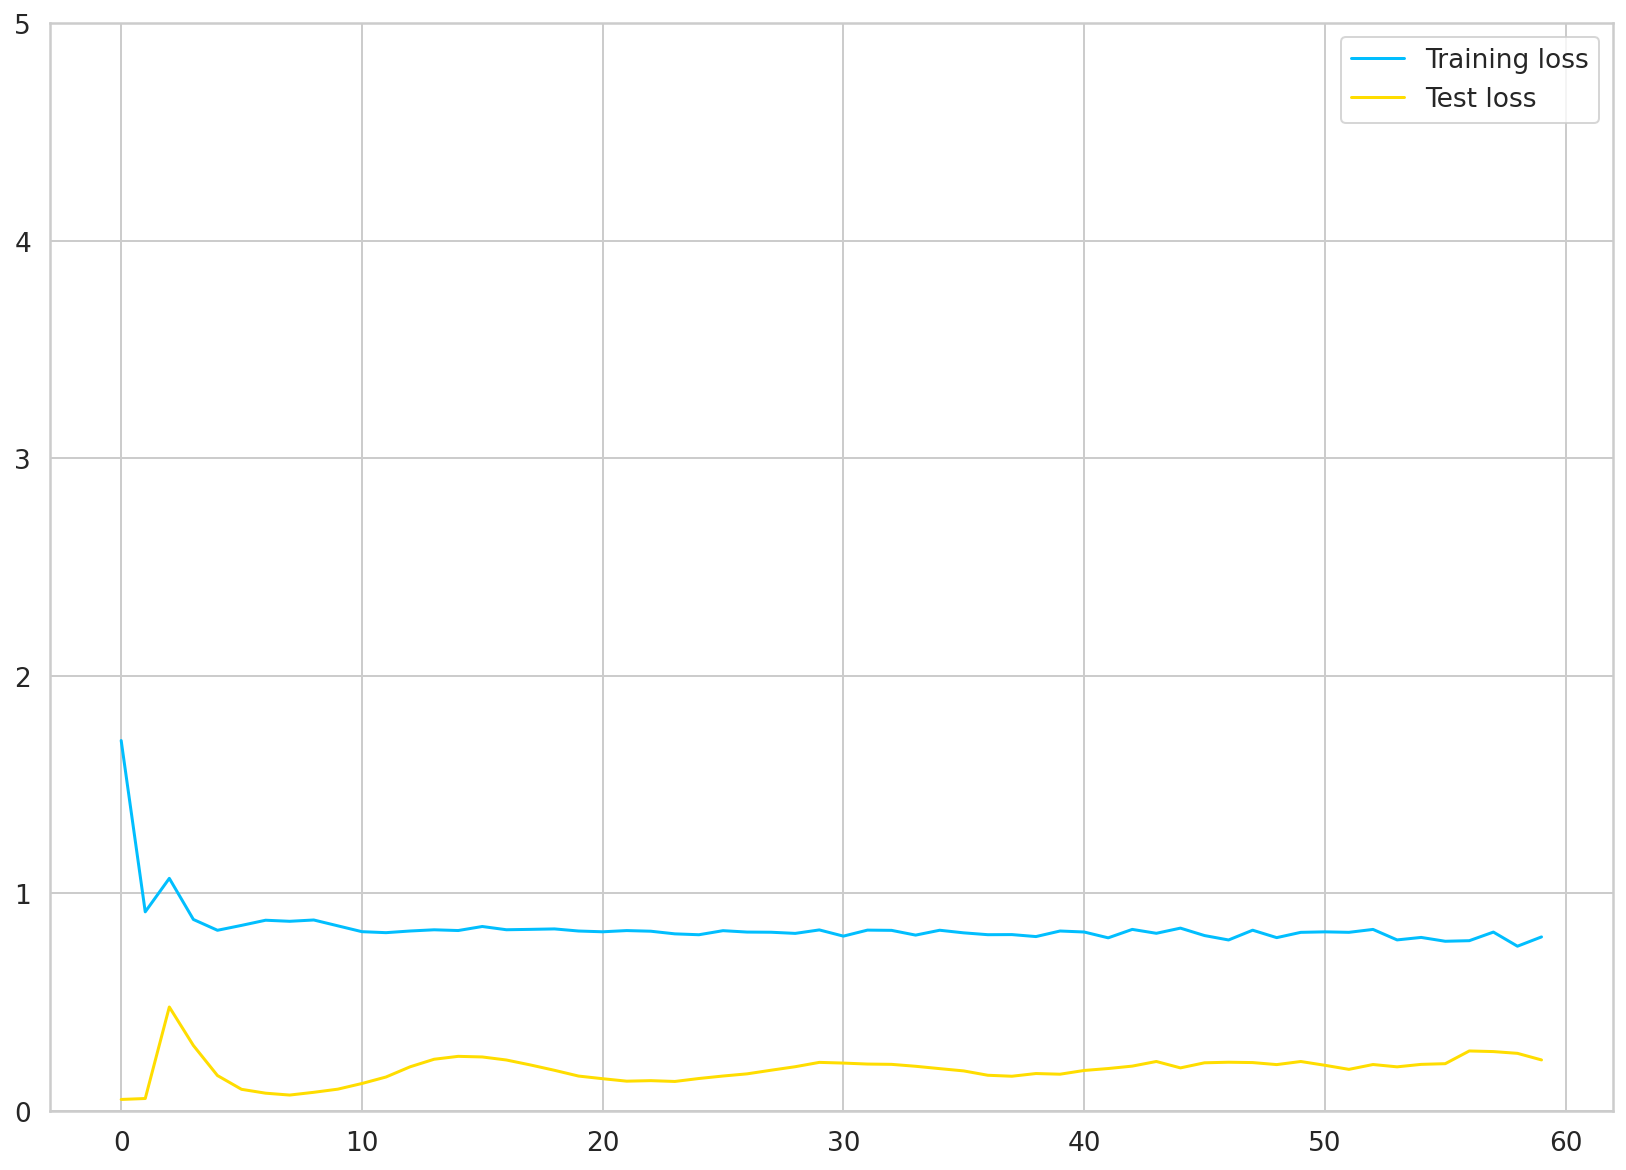

In [53]:
# Plot!
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend()

In [54]:
# Now we have the model that can predict the daily cases, but only a single day in future!

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [58]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

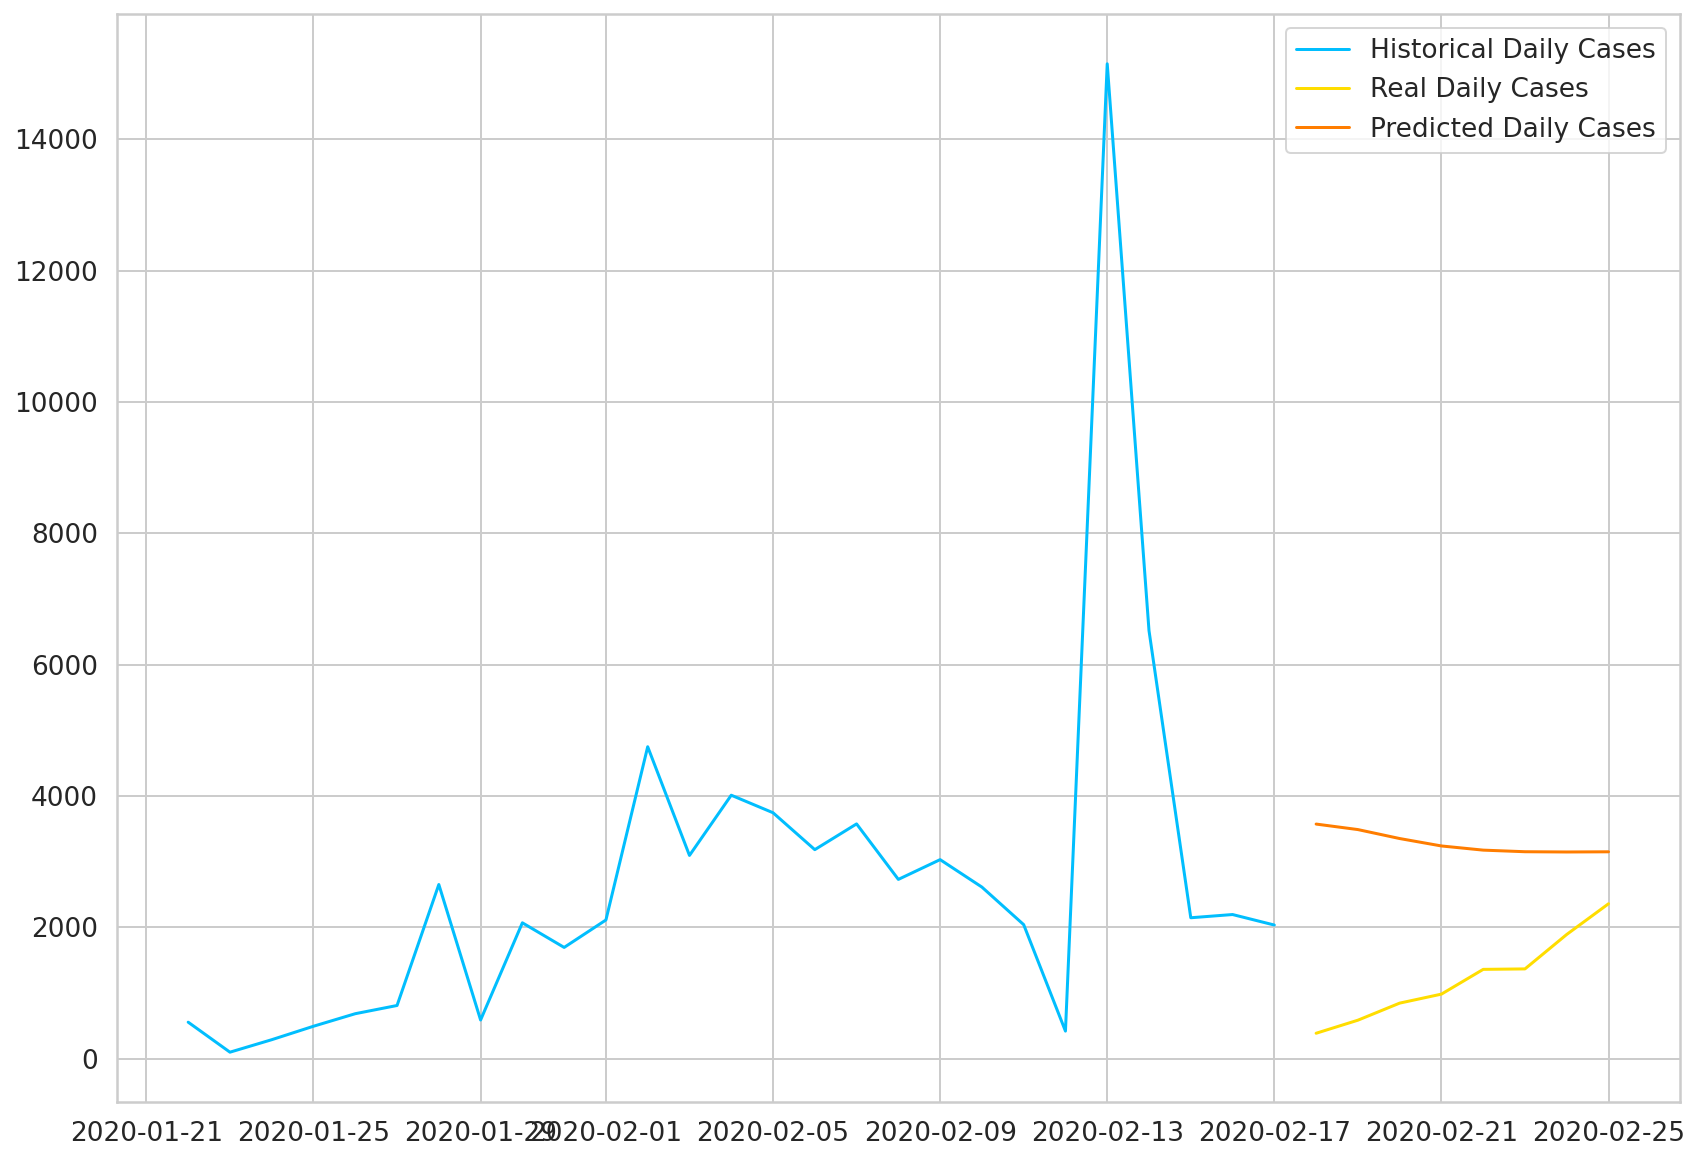

In [59]:
# So plot them all!

plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend()

In [60]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(41, 1)

In [61]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 1.4682836532592773
Epoch 10 train loss: 0.8243483304977417
Epoch 20 train loss: 0.8192060589790344
Epoch 30 train loss: 0.8273001313209534
Epoch 40 train loss: 0.8120766282081604
Epoch 50 train loss: 0.796294093132019


In [62]:
DAYS_TO_PREDICT = 12 # Set days total to predicted by the model!

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [63]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [64]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

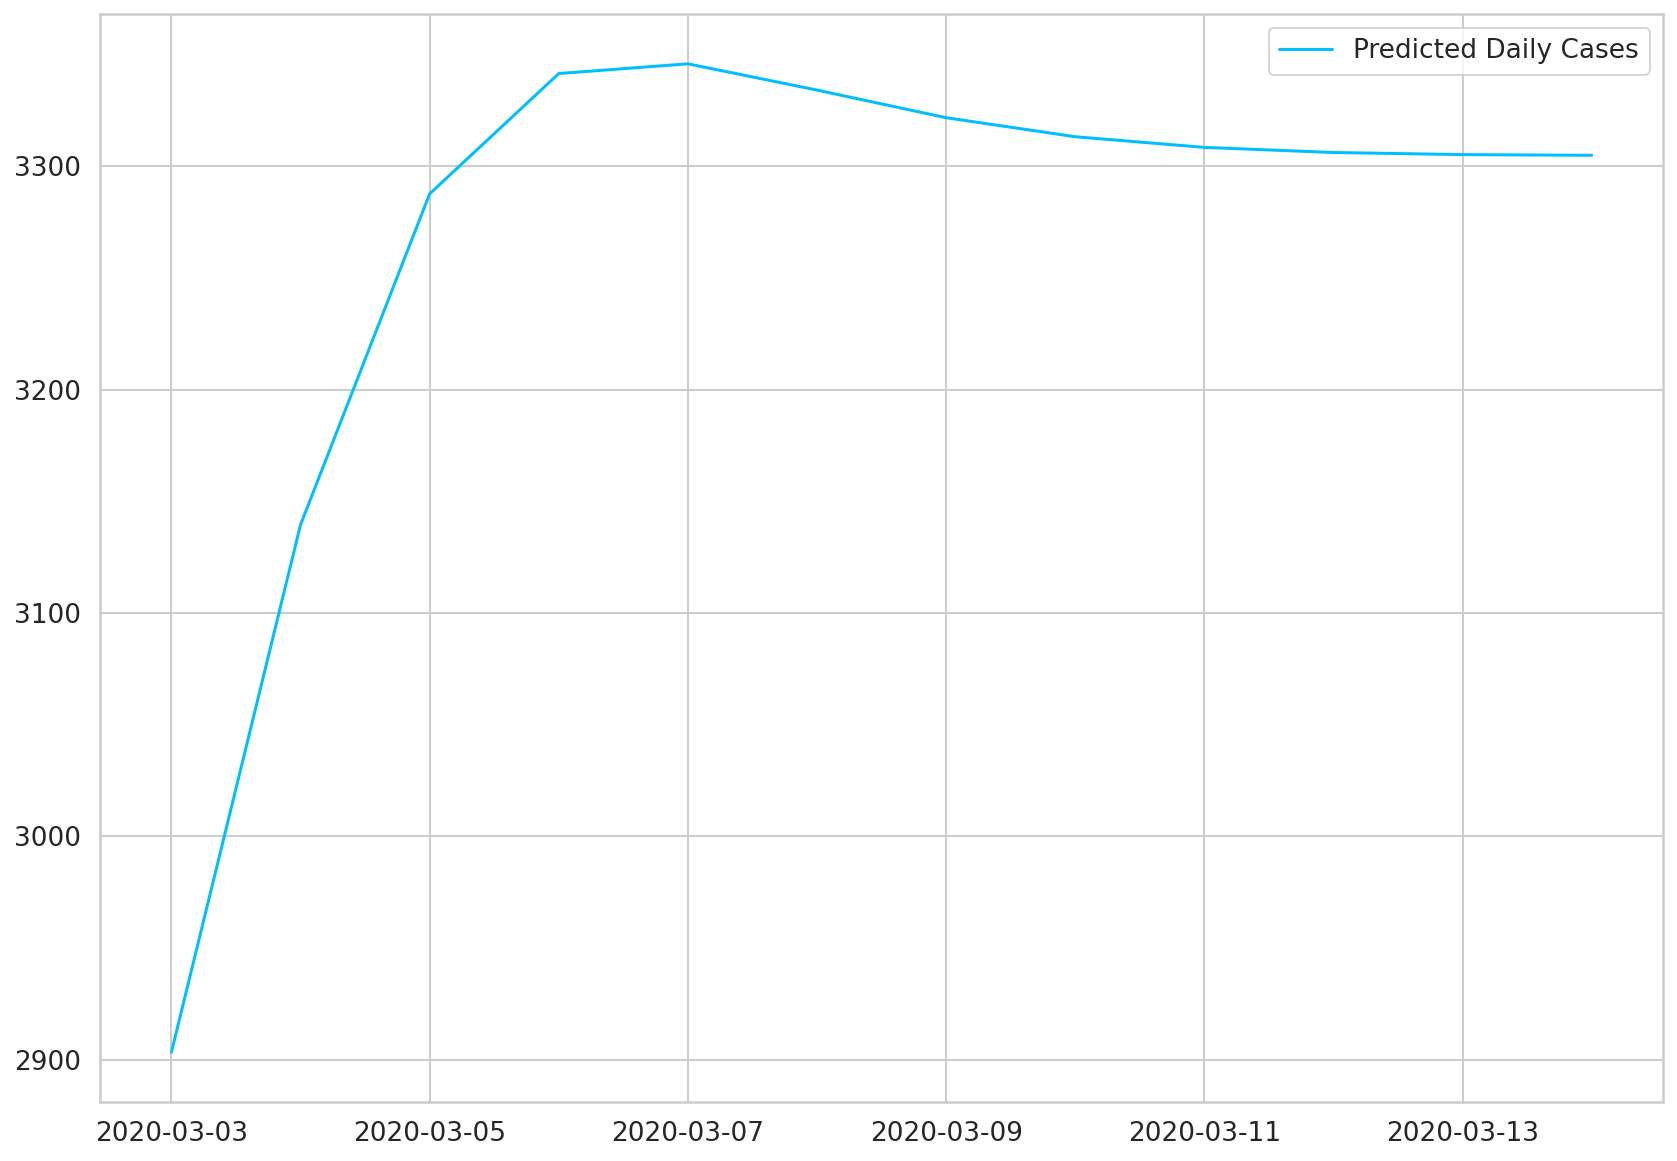

In [65]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

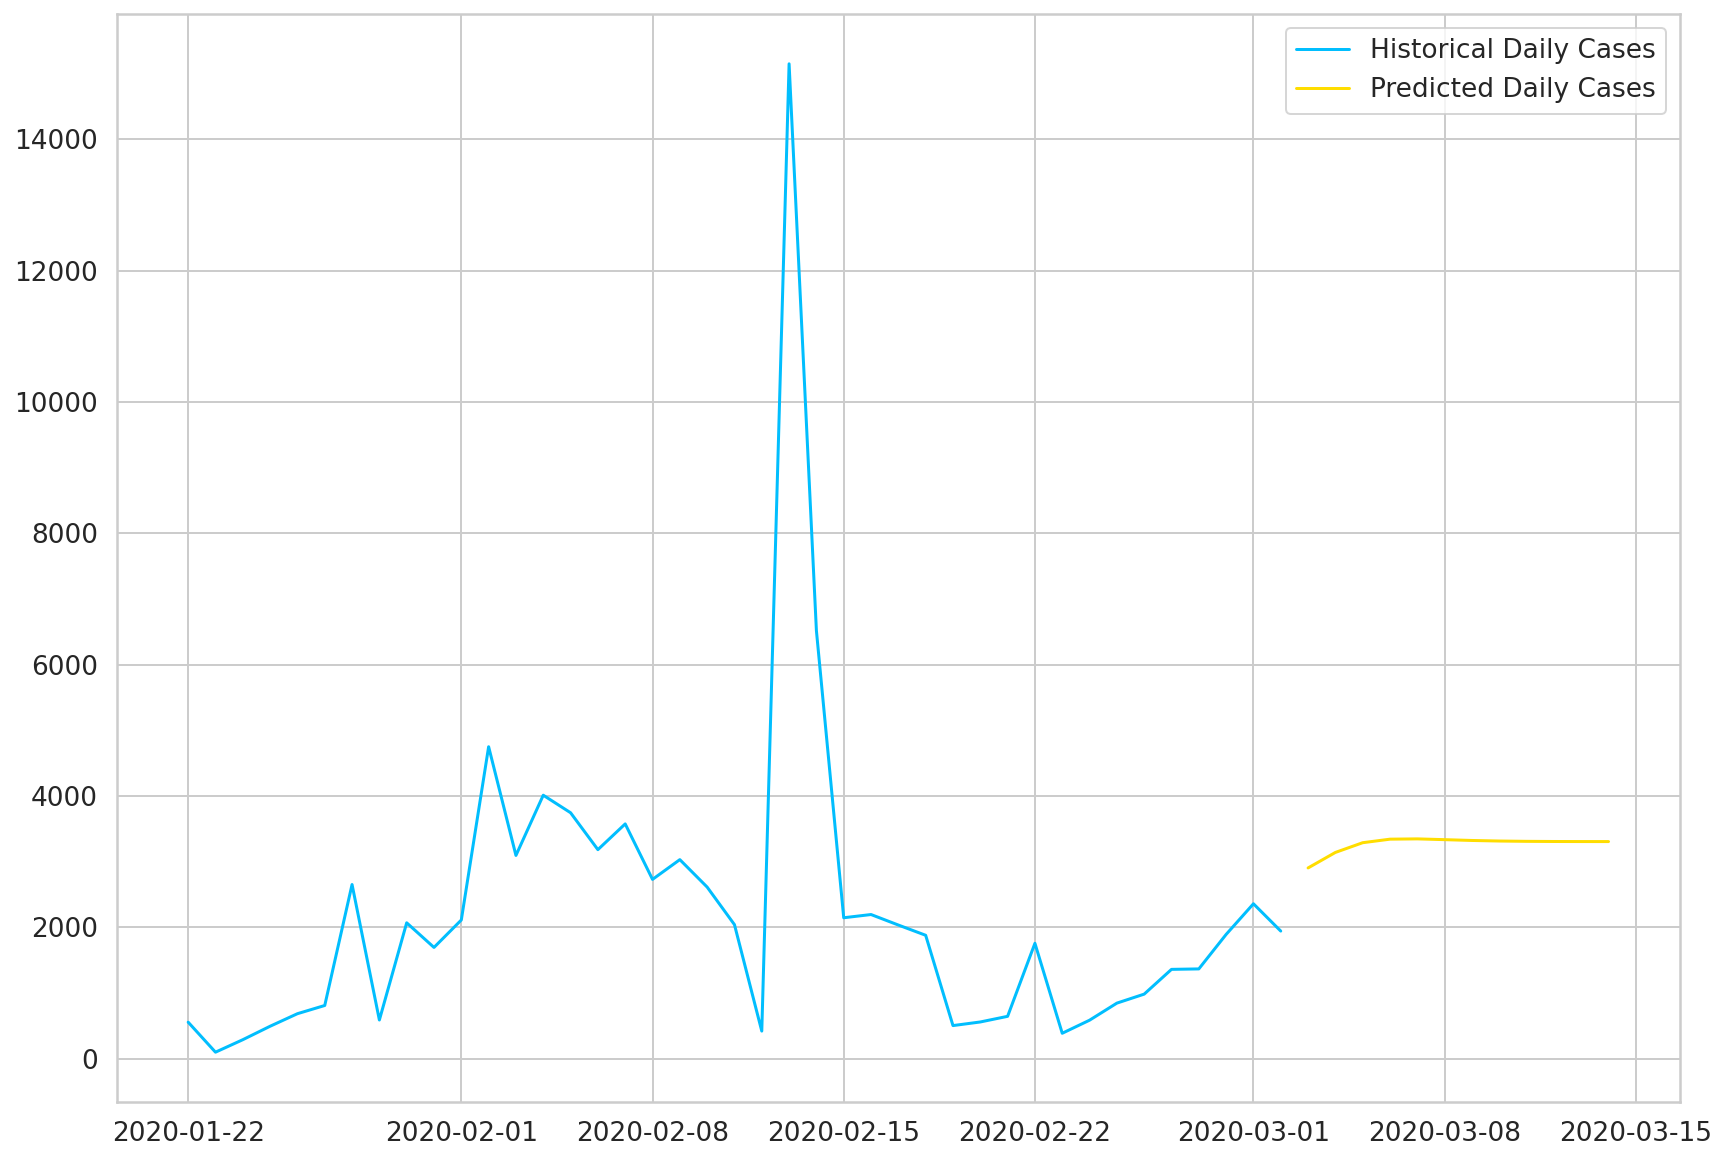

In [66]:
# Plot the result!

plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()